**Goal:** predict how many calories are burnt during a workout.
**Metrics:** RMSLE (Root Mean Square Log Error)

In [133]:
import os
import gc
import yaml
import xgboost as xgb
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import root_mean_squared_log_error

%matplotlib inline

In [134]:
with open("./../config.yml", "r") as fh:
    config = yaml.safe_load(fh)
    fh.close()

In [135]:
train_df = pl.read_csv(os.path.join(config["data"]["path"]["inp"], "train.csv"))
test_df = pl.read_csv(os.path.join(config["data"]["path"]["inp"], "test.csv"))
ss_df = pl.read_csv(os.path.join(config["data"]["path"]["inp"], "sample_submission.csv"))

In [136]:
train_df.head()

id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
i64,str,i64,f64,f64,f64,f64,f64,f64
0,"""male""",36,189.0,82.0,26.0,101.0,41.0,150.0
1,"""female""",64,163.0,60.0,8.0,85.0,39.7,34.0
2,"""female""",51,161.0,64.0,7.0,84.0,39.8,29.0
3,"""male""",20,192.0,90.0,25.0,105.0,40.7,140.0
4,"""female""",38,166.0,61.0,25.0,102.0,40.6,146.0


so, we have 8 columns and target as Calories. Workout duration I assume to be in minutes, Heart Rate in BPS, Body Temp in Celcius, Height in cm, weight in Kg.

In [137]:
len(train_df), len(test_df)

(750000, 250000)

In [138]:
train_df['Calories'].describe()

statistic,value
str,f64
"""count""",750000.0
"""null_count""",0.0
"""mean""",88.282781
"""std""",62.395349
"""min""",1.0
"""25%""",34.0
"""50%""",77.0
"""75%""",136.0
"""max""",314.0


<Axes: >

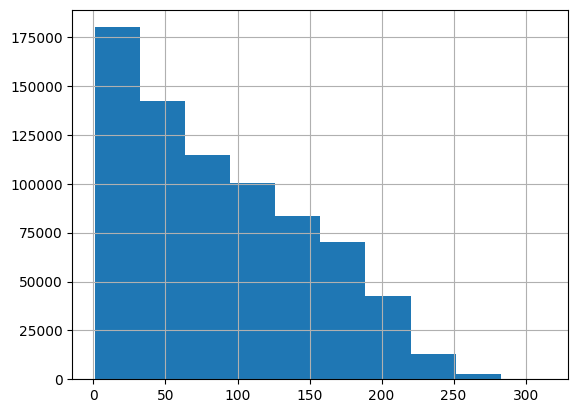

In [139]:
train_df['Calories'].to_pandas().hist()

In [140]:
y = train_df["Calories"].to_numpy()
y_log1p = np.log1p(y)

(array([  3081.,  11103.,  24812.,  40201.,  58387.,  79358., 126449.,
        157910., 190319.,  58380.]),
 array([0.69314718, 1.19908973, 1.70503227, 2.21097482, 2.71691736,
        3.22285991, 3.72880246, 4.234745  , 4.74068755, 5.24663009,
        5.75257264]),
 <BarContainer object of 10 artists>)

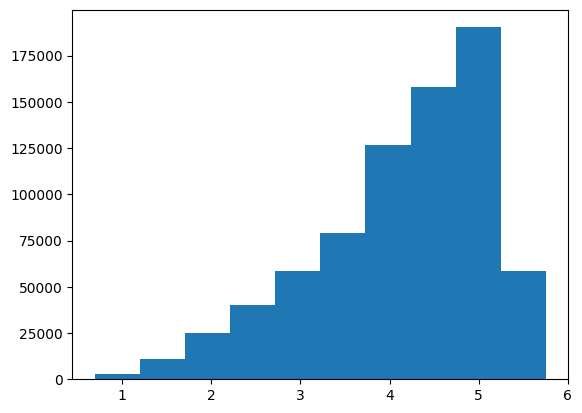

In [141]:
plt.hist(y_log1p)

In [142]:
# handle categorical values
# map male to 1, female to -1
train_df = train_df.with_columns(
    pl.when(
        pl.col("Sex") == "male"
    ).then(1)
    .otherwise(-1).alias("Sex")
)

test_df = test_df.with_columns(
    pl.when(
        pl.col("Sex") == "male"
    ).then(1).otherwise(-1).alias("Sex")
)

In [143]:
# create log calories column for qcut
train_df = train_df.with_columns(
    pl.Series("logCalories", y_log1p)
)

In [144]:
train_df = train_df.with_columns(
    pl.col("logCalories").qcut(
        [0, 0.25, 0.5, 0.75, 1], 
        labels=["l1", "l2", "l3", "l4", "l5", "l6"]).alias("Calories_qcut")
)

In [145]:
xgb_params = {
        "subsample": 0.7,
        "colsample_bytree": 0.45,
        "max_depth": 6,
        "learning_rate": 0.006,
        "objective": "reg:squarederror",
        "nthread": -1,
        # 'tree_method': 'gpu_hist',
        "max_bin": 168, 
        'min_child_weight': 3,
        'reg_lambda': 0.006,
        'reg_alpha': 0.04, 
        'seed' : 42,
}

In [147]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = skf.split(X=train_df, y=train_df["Calories_qcut"])

oof_predictions = np.zeros(len(train_df))

dtest = xgb.DMatrix(test_df)
y_test = np.zeros(len(test_df))

for fold, (train_idx, val_idx) in enumerate(splits):
    print(f"Fold: {fold}")
    x_train, y_train = train_df[train_idx].drop("Calories_qcut"), y_log1p[train_idx]
    x_val, y_val = train_df[val_idx].drop("Calories_qcut"), y_log1p[val_idx]

    # create a xgb model with default params
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, label=y_val)

    # train the model
    model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=10000,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=500,
        verbose_eval=1000
    )

    # predict the validation set
    y_pred = model.predict(dval)
    # inverse transform the predictions
    y_pred = np.expm1(y_pred)
    oof_predictions[val_idx] = y_pred
    oof_score = root_mean_squared_log_error(y_true=np.expm1(y_val), y_pred=y_pred)
    print(f"Fold: {fold}, OOF score: {oof_score}")

    # predict the test set
    y_test_fold = model.predict(dtest)
    # inverse transform the predictions
    y_test_fold = np.expm1(y_test_fold)
    y_test += y_test_fold / skf.n_splits

    del x_train, y_train, x_val, y_val, dtrain, dval, y_pred, y_test_fold
    _ = gc.collect()

Fold: 0
[0]	train-rmse:0.95744	val-rmse:0.95751
[1000]	train-rmse:0.02083	val-rmse:0.02078
[2000]	train-rmse:0.01679	val-rmse:0.01689
[3000]	train-rmse:0.01541	val-rmse:0.01569
[4000]	train-rmse:0.01464	val-rmse:0.01507
[5000]	train-rmse:0.01409	val-rmse:0.01470
[6000]	train-rmse:0.01365	val-rmse:0.01442
[7000]	train-rmse:0.01326	val-rmse:0.01420
[8000]	train-rmse:0.01293	val-rmse:0.01403
[9000]	train-rmse:0.01262	val-rmse:0.01387
[9999]	train-rmse:0.01233	val-rmse:0.01375
Fold: 0, OOF score: 0.013745017545829788
Fold: 1
[0]	train-rmse:0.95725	val-rmse:0.95827
[1000]	train-rmse:0.02078	val-rmse:0.02107
[2000]	train-rmse:0.01673	val-rmse:0.01723
[3000]	train-rmse:0.01536	val-rmse:0.01606
[4000]	train-rmse:0.01458	val-rmse:0.01547
[5000]	train-rmse:0.01404	val-rmse:0.01512
[6000]	train-rmse:0.01360	val-rmse:0.01485
[7000]	train-rmse:0.01321	val-rmse:0.01463
[8000]	train-rmse:0.01288	val-rmse:0.01447
[9000]	train-rmse:0.01258	val-rmse:0.01431
[9999]	train-rmse:0.01231	val-rmse:0.01418
Fol

In [148]:
root_mean_squared_log_error(y_true=y, y_pred=oof_predictions)

0.014021348769779956

(array([180046., 142508., 114690., 100568.,  83402.,  70406.,  42551.,
         12836.,   2777.,    216.]),
 array([  1. ,  32.3,  63.6,  94.9, 126.2, 157.5, 188.8, 220.1, 251.4,
        282.7, 314. ]),
 <BarContainer object of 10 artists>)

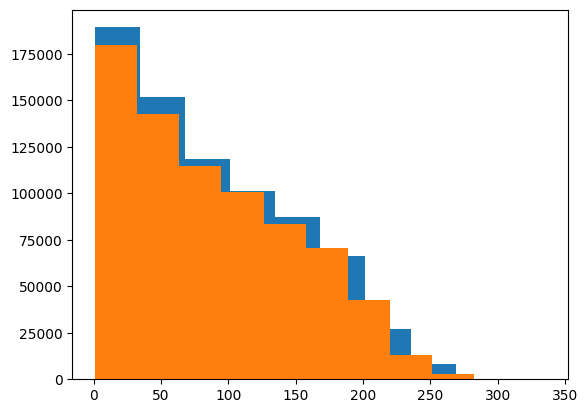

In [149]:
plt.hist(oof_predictions)
plt.hist(y)

(array([5.09000e+02, 3.52200e+03, 4.77800e+03, 1.31710e+04, 5.21840e+04,
        1.20359e+05, 4.84180e+04, 6.86500e+03, 1.80000e+02, 1.40000e+01]),
 array([137.94038963, 158.30132961, 178.66226959, 199.02320957,
        219.38414955, 239.74508953, 260.10602951, 280.46696949,
        300.82790947, 321.18884945, 341.54978943]),
 <BarContainer object of 10 artists>)

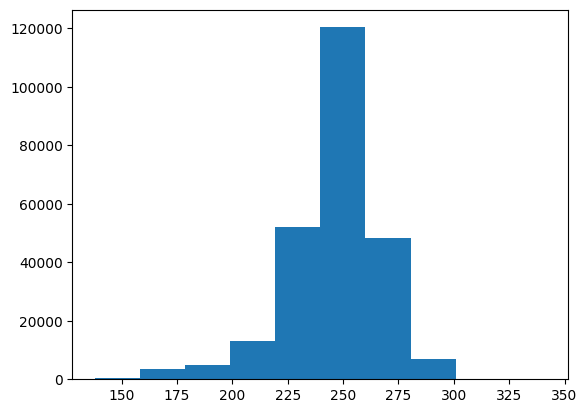

In [150]:
plt.hist(y_test)

In [151]:
ss_df = ss_df.with_columns(
    pl.Series(y_test).alias("Calories")
)
ss_df.write_csv(os.path.join(config["data"]["path"]["out"], "submission.csv"))

In [ ]:
ss_df

id,Calories
i64,f64
750000,276.69537
750001,278.365311
750002,287.602165
750003,278.557789
750004,287.573521
…,…
999995,275.680294
999996,261.742298
999997,284.405571
